## Part 01 - Data

In [1]:
!pip install -q -U watermark

In [3]:
!pip install plotly

  Using cached plotly-4.14.3-py2.py3-none-any.whl (13.2 MB)
  Using cached retrying-1.3.3.tar.gz (10 kB)
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=2a095cafa2e24cdfa95354bcb426734dac96d67a358c853bd709652b1e4197bb
  Stored in directory: c:\users\rafam\appdata\local\pip\cache\wheels\c4\a7\48\0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [4]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

import plotly.graph_objs as go

from plotly.offline import init_notebook_mode, iplot

#from torch import nn, optim

#import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
#torch.manual_seed(RANDOM_SEED)

In [5]:
# checking libraries

%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,sklearn

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.22.0

numpy     : 1.20.1
pandas    : 1.2.4
matplotlib: 3.3.4
sklearn   : 0.24.1



In [6]:
ls dataset

 O volume na unidade C nÆo tem nome.
 O N£mero de S‚rie do Volume ‚ 18F8-849B

 Pasta de C:\Users\rafam\Downloads\IA_Segmind\dataset

28/05/2021  12:50    <DIR>          .
28/05/2021  12:50    <DIR>          ..
31/03/2021  00:55           317.610 sample_submission.csv
10/12/2019  19:27            45.010 store.csv
31/03/2021  01:28         7.631.434 TEST.csv
31/03/2021  01:08        23.794.260 TRAIN.csv
               4 arquivo(s)     31.788.314 bytes
               2 pasta(s)   195.092.353.024 bytes dispon¡veis


In [8]:
## Loading datasets 

df_train = pd.read_csv('dataset/TRAIN.csv',low_memory=False)
df_test = pd.read_csv('dataset/TEST.csv',low_memory=False)
sample_submission = pd.read_csv('dataset/sample_submission.csv',low_memory=False)
store = pd.read_csv('dataset/store.csv',low_memory=False)

In [9]:
# Joining df_train and store and df_test and store by Store 

df_train = pd.merge(df_train, store, how="left",on="Store")
df_test = pd.merge(df_test, store, how="left",on="Store")

In [10]:
# Creating year, month and day columns from Date column

data_train=pd.to_datetime(df_train['Date'],format='%Y-%m-%d')

df_train['year']=data_train.dt.year
df_train['month']=data_train.dt.month
df_train['day']=data_train.dt.day

data_test=pd.to_datetime(df_test['Date'],format='%Y-%m-%d')

df_test['year']=data_test.dt.year
df_test['month']=data_test.dt.month
df_test['day']=data_test.dt.day

In [11]:
# Sales visualization if necessary


# store_daily_sales_sc = []
# for store in df_train['Store'].unique():
#     current_store_daily_sales = df_train[(df_train['Store'] == store)]
#     store_daily_sales_sc.append(go.Scatter(x=current_store_daily_sales['Date'], y=current_store_daily_sales['Sales'], name=('Store %s' % store)))

# layout = go.Layout(title='Store daily sales', xaxis=dict(title='Date'), yaxis=dict(title='Sales'))
# fig = go.Figure(data=store_daily_sales_sc, layout=layout)
# iplot(fig)

In [12]:
# Shape of data

df_train.shape, df_test.shape

((712046, 21), (305163, 19))

In [13]:
df_train = df_train.drop('Customers', axis=1)
df_train = df_train.drop('PromoInterval', axis=1)
df_test = df_test.drop('PromoInterval', axis=1)

### Cleaning up the Data: missing values and errors in the dataset

In [14]:
# checking unique values in each column

df_train['Open'].unique(), df_train['Promo'].unique(), df_train['StateHoliday'].unique() , df_train['SchoolHoliday'].unique(), df_train['StoreType'].unique(), df_train['Assortment'].unique(), df_train['CompetitionOpenSinceMonth'].unique(), df_train['CompetitionOpenSinceYear'].unique(), df_train['Promo2'].unique(), df_train['Promo2SinceWeek'].unique(), df_train['Promo2SinceYear'].unique()

(array([1, 0], dtype=int64),
 array([1, 0], dtype=int64),
 array(['0', 'a', 'b', 'c'], dtype=object),
 array([1, 0], dtype=int64),
 array(['c', 'a', 'd', 'b'], dtype=object),
 array(['a', 'c', 'b'], dtype=object),
 array([ 9., 11., 12.,  4., 10.,  8., nan,  3.,  6.,  5.,  1.,  2.,  7.]),
 array([2008., 2007., 2006., 2009., 2015., 2013., 2014., 2000., 2011.,
          nan, 2010., 2005., 1999., 2003., 2012., 2004., 2002., 1961.,
        1995., 2001., 1990., 1994., 1900., 1998.]),
 array([0, 1], dtype=int64),
 array([nan, 13., 14.,  1., 45., 40., 26., 22.,  5.,  6., 10., 31., 37.,
         9., 39., 27., 18., 35., 23., 48., 36., 50., 44., 49., 28.]),
 array([  nan, 2010., 2011., 2012., 2009., 2014., 2015., 2013.]))

In [15]:
# for StateHoliday we have 0 and '0'

df_train['StateHoliday'].value_counts()

0    688940
a     14546
b      4460
c      4100
Name: StateHoliday, dtype: int64

In [16]:
# Converting StateHoliday to numeric

df_train['StateHoliday'] = df_train['StateHoliday'].replace({'0':0, np.nan:0})
df_train['StateHoliday'] = df_train['StateHoliday'].replace({'a':1})
df_train['StateHoliday'] = df_train['StateHoliday'].replace({'b':2})
df_train['StateHoliday'] = df_train['StateHoliday'].replace({'c':3})


df_test['StateHoliday'] = df_test['StateHoliday'].replace({'0':0, np.nan:0})
df_test['StateHoliday'] = df_test['StateHoliday'].replace({'a':1})
df_test['StateHoliday'] = df_test['StateHoliday'].replace({'b':2})
#df_test['StateHoliday'] = df_test['StateHoliday'].replace({'c':3})


In [17]:
df_train['StateHoliday'].value_counts()

0    688940
1     14546
2      4460
3      4100
Name: StateHoliday, dtype: int64

In [18]:
# For StoreType

df_train['StoreType'].value_counts()

a    386873
d    217674
c     96322
b     11177
Name: StoreType, dtype: int64

In [19]:
# Converting StoreType to numeric
df_train['StoreType'] = df_train['StoreType'].replace({'d':4})
df_train['StoreType'] = df_train['StoreType'].replace({'a':1})
df_train['StoreType'] = df_train['StoreType'].replace({'b':2})
df_train['StoreType'] = df_train['StoreType'].replace({'c':3})


df_test['StoreType'] = df_test['StoreType'].replace({'d':4})
df_test['StoreType'] = df_test['StoreType'].replace({'a':1})
df_test['StoreType'] = df_test['StoreType'].replace({'b':2})
df_test['StoreType'] = df_test['StoreType'].replace({'c':3})

In [20]:
df_train['StoreType'].value_counts()

1    386873
4    217674
3     96322
2     11177
Name: StoreType, dtype: int64

In [21]:
# For StoreType

df_train['Assortment'].value_counts()

a    375158
c    331058
b      5830
Name: Assortment, dtype: int64

In [22]:
# Converting Assortment to numeric
df_train['Assortment'] = df_train['Assortment'].replace({'a':0})
df_train['Assortment'] = df_train['Assortment'].replace({'b':1})
df_train['Assortment'] = df_train['Assortment'].replace({'c':2})

df_test['Assortment'] = df_test['Assortment'].replace({'a':0})
df_test['Assortment'] = df_test['Assortment'].replace({'b':1})
df_test['Assortment'] = df_test['Assortment'].replace({'c':2})

In [23]:
df_train['Assortment'].value_counts()

0    375158
2    331058
1      5830
Name: Assortment, dtype: int64

In [24]:
# Checking for missing values
print(df_train.isna().sum()), print("______________________________"), print(df_test.isna().sum())

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            1821
CompetitionOpenSinceMonth    226460
CompetitionOpenSinceYear     226460
Promo2                            0
Promo2SinceWeek              359143
Promo2SinceYear              359143
year                              0
month                             0
day                               0
dtype: int64
______________________________
Store                             0
DayOfWeek                         0
Date                              0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType           

(None, None, None)

In [25]:
# fill NaN values with 0

df_train = df_train.fillna(0)
df_test = df_test.fillna(0)


In [26]:
print(df_train.isna().sum()), print("______________________________"), print(df_test.isna().sum())

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
year                         0
month                        0
day                          0
dtype: int64
______________________________
Store                        0
DayOfWeek                    0
Date                         0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear  

(None, None, None)

In [27]:
# Saving data index and Date

df_train_index = df_train.index
df_test_index = df_test.index

df_train_date = df_train["Date"]
df_test_date = df_test["Date"]

In [28]:
df_test_index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            305153, 305154, 305155, 305156, 305157, 305158, 305159, 305160,
            305161, 305162],
           dtype='int64', length=305163)

In [29]:
# Removing Date

df_train = df_train.drop('Date', axis=1)
df_test = df_test.drop('Date', axis=1)

In [30]:
# Data Shape
print(df_train.shape), print(df_test.shape)

(712046, 18)
(305163, 17)


(None, None)

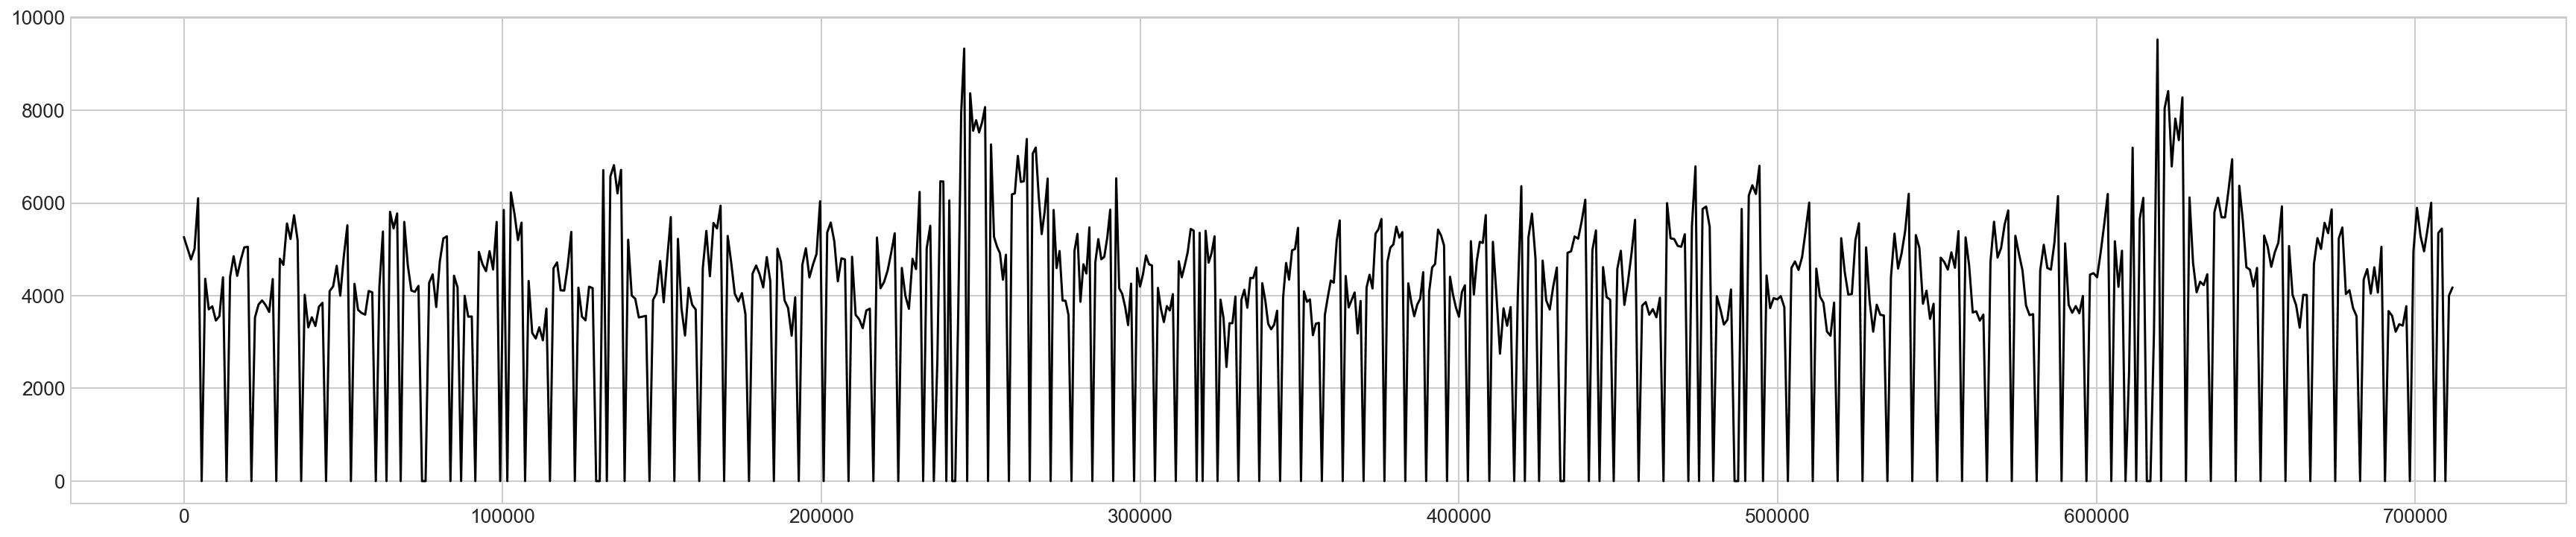

In [31]:
# Sales visualization for the first store

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

y = df_train.loc[df_train['Store'] == 1]['Sales']


fig= plt.figure(figsize=(30,6))
plt.plot( y, '-', color='black')


In [32]:
# Sort columns

df_train = df_train[['Store', 'DayOfWeek', 'year','month','day', 'Open', 'Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','Sales']]
df_test = df_test[['Store', 'DayOfWeek', 'year','month','day', 'Open', 'Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear']]

In [33]:
df_train.head(5)

,Store,DayOfWeek,year,month,day,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales
0,1,5,2015,7,31,1,1,0,1,3,0,1270.0,9.0,2008.0,0,0.0,0.0,5263
1,2,5,2015,7,31,1,1,0,1,1,0,570.0,11.0,2007.0,1,13.0,2010.0,6064
2,3,5,2015,7,31,1,1,0,1,1,0,14130.0,12.0,2006.0,1,14.0,2011.0,8314
3,4,5,2015,7,31,1,1,0,1,3,2,620.0,9.0,2009.0,0,0.0,0.0,13995
4,5,5,2015,7,31,1,1,0,1,1,0,29910.0,4.0,2015.0,0,0.0,0.0,4822


In [34]:
x_train = df_train.drop(['Sales'],axis=1)
y_train = df_train['Sales']

In [35]:
train_stats=df_train.describe()
train_stats.pop('Sales')
train_stats=train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Store,712046.0,558.427662,321.965298,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,712046.0,3.999787,1.996273,1.0,2.0,4.0,6.0,7.0
year,712046.0,2014.188989,0.662752,2013.0,2014.0,2014.0,2015.0,2015.0
month,712046.0,6.196426,3.539482,1.0,3.0,6.0,10.0,12.0
day,712046.0,15.727827,8.783917,1.0,8.0,16.0,23.0,31.0
Open,712046.0,0.828574,0.376881,0.0,1.0,1.0,1.0,1.0
Promo,712046.0,0.380600,0.485535,0.0,0.0,0.0,1.0,1.0
StateHoliday,712046.0,0.050230,0.307868,0.0,0.0,0.0,0.0,3.0
SchoolHoliday,712046.0,0.172167,0.377526,0.0,0.0,0.0,0.0,1.0
StoreType,712046.0,2.203353,1.363840,1.0,1.0,1.0,4.0,4.0


In [36]:
test_stats=df_test.describe()

test_stats=test_stats.T
test_stats

,count,mean,std,min,25%,50%,75%,max
Store,305163.0,558.434545,321.776964,1.0,280.0,559.0,837.0,1115.0
DayOfWeek,305163.0,3.994967,1.999997,1.0,2.0,4.0,6.0,7.0
year,305163.0,2013.000000,0.000000,2013.0,2013.0,2013.0,2013.0,2013.0
month,305163.0,5.030882,2.587206,1.0,3.0,5.0,7.0,10.0
day,305163.0,15.644370,8.796049,1.0,8.0,16.0,23.0,31.0
Open,305163.0,0.833682,0.372366,0.0,1.0,1.0,1.0,1.0
Promo,305163.0,0.383647,0.486274,0.0,0.0,0.0,1.0,1.0
StateHoliday,305163.0,0.033340,0.216433,0.0,0.0,0.0,0.0,2.0
SchoolHoliday,305163.0,0.193765,0.395248,0.0,0.0,0.0,0.0,1.0
StoreType,305163.0,2.217064,1.368908,1.0,1.0,1.0,4.0,4.0


In [37]:

def norm_train(x):
  return( (x - train_stats['mean']) / train_stats['std'] ) #z-score standardization "(x-mean)/sd"

#to remove outliers normalising whole data
norm_x_train = norm_train(x_train) #normalised train_data




In [38]:
def norm_test(x):
  return( (x - test_stats['mean']) / test_stats['std'] ) #z-score standardization "(x-mean)/sd"

#to remove outliers normalising whole data
norm_test = norm_test(df_test) #normalised test_data


## Part 02 - Model and Predictions

### XGBOOST

In [39]:
import xgboost as xgb

In [40]:
def xboost(x_train, y_train, x_test):
    """Trains xgboost model and returns Series of predictions for x_test"""
    dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=list(x_train.columns))
    dtest = xgb.DMatrix(x_test, feature_names=list(x_test.columns))

    # params = {'max_depth':6,
    #           'eta':0.2,
    #           'silent':1,
    #           'subsample':1}
    params = {
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.2,
    'subsample': 1,
    'colsample_bytree': 1,
    'objective':'reg:squarederror'}
    num_rounds = 1500

    bst = xgb.train(params, dtrain, num_rounds)
    
    return pd.Series(bst.predict(dtest))

In [41]:
preds = xboost(norm_x_train, y_train, norm_test)

In [42]:
preds.shape

(305163,)

In [43]:
preds_reshape = np.asarray(preds).reshape(305163,1)
preds_reshape.shape

(305163, 1)

In [44]:
test = np.concatenate((np.asarray(df_test), preds_reshape), axis=1)


In [45]:
df_test.shape

(305163, 17)

In [46]:
preds.shape

(305163,)

In [47]:
test.shape

(305163, 18)

In [48]:
recon = pd.DataFrame(test, columns=df_train.columns)

In [49]:
recon

,Store,DayOfWeek,year,month,day,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales
0,767.0,1.0,2013.0,4.0,1.0,0.0,0.0,2.0,1.0,1.0,2.0,13080.0,0.0,0.0,0.0,0.0,0.0,-694.198120
1,1111.0,6.0,2013.0,3.0,16.0,1.0,0.0,0.0,0.0,1.0,0.0,1900.0,6.0,2014.0,1.0,31.0,2013.0,4464.202637
2,45.0,4.0,2013.0,8.0,1.0,1.0,1.0,0.0,1.0,4.0,0.0,9710.0,2.0,2014.0,0.0,0.0,0.0,6882.724609
3,500.0,4.0,2013.0,5.0,23.0,1.0,0.0,0.0,1.0,4.0,2.0,10690.0,9.0,2007.0,1.0,5.0,2013.0,5687.691406
4,82.0,2.0,2013.0,8.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,22390.0,4.0,2008.0,1.0,37.0,2009.0,7209.722656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305158,412.0,2.0,2013.0,5.0,28.0,1.0,1.0,0.0,1.0,4.0,2.0,4460.0,0.0,0.0,1.0,39.0,2010.0,10585.634766
305159,936.0,6.0,2013.0,3.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,580.0,2.0,2008.0,0.0,0.0,0.0,5674.494141
305160,21.0,1.0,2013.0,9.0,16.0,1.0,0.0,0.0,0.0,3.0,2.0,550.0,10.0,1999.0,1.0,45.0,2009.0,8918.525391
305161,1077.0,6.0,2013.0,6.0,22.0,1.0,0.0,0.0,0.0,1.0,0.0,3750.0,11.0,2001.0,1.0,35.0,2010.0,3677.291016


In [50]:
recon['Date'] = pd.to_datetime((recon['year']*10000+recon['month']*100+recon['day']).apply(str),format='%Y%m%d')
df_train['Date'] = pd.to_datetime((df_train['year']*10000+df_train['month']*100+df_train['day']).apply(str),format='%Y%m%d')


In [51]:
recon.head(5)

,Store,DayOfWeek,year,month,day,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales,Date
0,767.0,1.0,2013.0,4.0,1.0,0.0,0.0,2.0,1.0,1.0,2.0,13080.0,0.0,0.0,0.0,0.0,0.0,-694.198120,2013-04-01
1,1111.0,6.0,2013.0,3.0,16.0,1.0,0.0,0.0,0.0,1.0,0.0,1900.0,6.0,2014.0,1.0,31.0,2013.0,4464.202637,2013-03-16
2,45.0,4.0,2013.0,8.0,1.0,1.0,1.0,0.0,1.0,4.0,0.0,9710.0,2.0,2014.0,0.0,0.0,0.0,6882.724609,2013-08-01
3,500.0,4.0,2013.0,5.0,23.0,1.0,0.0,0.0,1.0,4.0,2.0,10690.0,9.0,2007.0,1.0,5.0,2013.0,5687.691406,2013-05-23
4,82.0,2.0,2013.0,8.0,6.0,1.0,0.0,0.0,1.0,1.0,0.0,22390.0,4.0,2008.0,1.0,37.0,2009.0,7209.722656,2013-08-06


In [52]:
y2 = recon['Sales']

y2.describe()

count    305163.000000
mean       6079.131889
std        3679.812943
min       -4309.196289
25%        4308.597168
50%        6293.748047
75%        8283.174316
max       35999.753906
Name: Sales, dtype: float64

In [53]:
df_train['Sales'].describe()

count    712046.000000
mean       5872.082608
std        3918.569033
min           0.000000
25%        3795.000000
50%        5848.000000
75%        7991.000000
max       41551.000000
Name: Sales, dtype: float64

In [54]:
# organizing the data in Store and Date

df_train2 = df_train.sort_values(["Store", "Date"])
recon2 = recon.sort_values(["Store", "Date"])

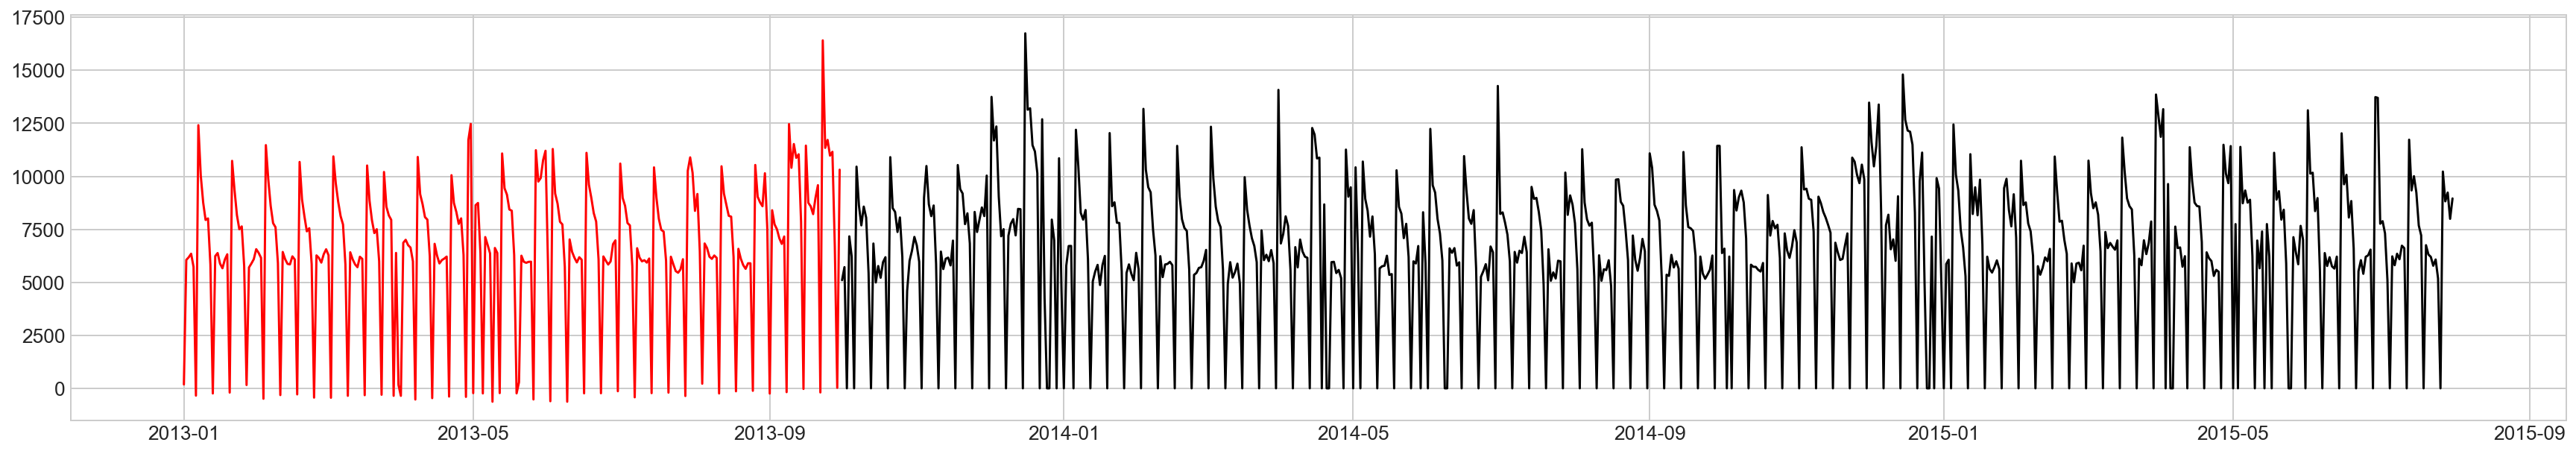

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#x = df2['Data/hora']
y = df_train2.loc[df_train['Store']==12]['Sales']
y2 = recon2.loc[recon['Store']==12]['Sales']
x = df_train2.loc[df_train['Store']==12]['Date']
x2 = recon2.loc[recon['Store']==12]['Date']
fig1= plt.figure(figsize=(30,5))
plt.plot( x2, y2,  '-', color='red')
plt.plot( x, y, '-', color='black')



In [56]:
preds

0          -694.198120
1          4464.202637
2          6882.724609
3          5687.691406
4          7209.722656
              ...     
305158    10585.634766
305159     5674.494141
305160     8918.525391
305161     3677.291016
305162     7315.506348
Length: 305163, dtype: float32

In [57]:
result=recon['Sales']

In [58]:
result_csv = result.to_csv('results.csv',index=True, index_label='Index')

In [59]:
pd.read_csv('results.csv')

,Index,Sales
0,0,-694.198120
1,1,4464.202637
2,2,6882.724609
3,3,5687.691406
4,4,7209.722656
...,...,...
305158,305158,10585.634766
305159,305159,5674.494141
305160,305160,8918.525391
305161,305161,3677.291016
